<a href="https://colab.research.google.com/github/Ak-Gautam/efficient_llm_fine_tunes/blob/main/mistral7b_03/Mistral_v0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Finetuning Mistral- v0.3 using Unsloth
The code was basically provided by Unsloth, it is an amazing tool! <a href="https://github.com/unslothai/unsloth">Unsloth Github</a>

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes


- **max_seq_len**: how many tokens the model should be able to handle. Choose the smallest length that still staisfies your application requirements.
- **model_name**: Huggingface base model that we want to finetune. Make sure this model will fit in the vram you have. (For T4 its 14.9Gb)

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/137k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

- **r** : This is the rank of the low-rank matrices used in the LoRA technique. A higher rank generally means better performance but also increased memory usage. Typical values are 8, 16, 32, 64, or 128.
- **target_modules** : These are the modules of the model where the LoRA layers will be added. print(model) to get all the layers.
- **lora_alpha** : This parameter controls the scaling factor for the LoRA layers. A higher value generally means faster convergence during fine-tuning but may also lead to overfitting.
- **lora_dropout** : This parameter sets the dropout rate for the LoRA layers. In this case, it is set to 0, which is optimized for performance.
- **bias** : This parameter specifies how to handle the bias terms in the LoRA layers. Setting it to "none" means that no bias terms will be added, which is optimized for performance.
- **use_rslora** : This parameter determines whether to use Rank Stabilized LoRA (RSLoRA), which is a variant of LoRA that can improve stability during fine-tuning.
- **loftq_config** : This parameter is related to LoftQ, which is a quantization technique for further reducing memory usage, not needed here.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


We are finetuning this model for conversation where we have human ask something and AI accomodate it. As suggested by Unsloth we will use the `ChatML` format for conversation style finetunes. We use [Open Assistant conversations](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style. ChatML renders multi turn conversations.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
# This dataset has 250k rows but we will only use 15000 rows for efficiency.
dataset = load_dataset("glouriousgautam/openhermes250k", split = "train")
shuffled_dataset = dataset.shuffle(seed=42)
# Select the first 18,000 rows
dataset = shuffled_dataset.select(range(18000))

dataset = dataset.map(formatting_prompts_func, batched = True,)

Unsloth: Not a fast tokenizer, so can't process it as of yet :(
Please log a Github issue if you want this as a new feature!
Your chat template will still work, but it won't add or edit tokens.


Generating train split:   0%|          | 0/250000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [ ]:
# Checking the dataset
dataset[5]["conversations"]

[{'from': 'human',
  'value': 'How can a Social Media Manager utilize their skillset to enhance the effectiveness of a digital marketing campaign? Can you provide an extended metaphor that illustrates the multi-faceted nature of their role and how they can cultivate a strong online presence and foster a loyal following within the [ marketing ] industry?\nIn terms of R code, how can we analyze social media metrics and engagement levels to measure the impact of a Social Media Manager on a campaign? Can we use tools such as sentiment analysis and network analysis to gain deeper insights into audience behavior and preferences?',
  'weight': None},
 {'from': 'gpt',
  'value': 'A Social Media Manager is like the conductor of an orchestra. They must bring together various elements, such as content creation, community management, and data analysis, to create a harmonious and effective digital marketing campaign. Just as a conductor must listen to and work with each individual musician, a Socia

In [ ]:
print(dataset[5]["text"])

<|im_start|>user
How can a Social Media Manager utilize their skillset to enhance the effectiveness of a digital marketing campaign? Can you provide an extended metaphor that illustrates the multi-faceted nature of their role and how they can cultivate a strong online presence and foster a loyal following within the [ marketing ] industry?
In terms of R code, how can we analyze social media metrics and engagement levels to measure the impact of a Social Media Manager on a campaign? Can we use tools such as sentiment analysis and network analysis to gain deeper insights into audience behavior and preferences?<|im_end|>
<|im_start|>assistant
A Social Media Manager is like the conductor of an orchestra. They must bring together various elements, such as content creation, community management, and data analysis, to create a harmonious and effective digital marketing campaign. Just as a conductor must listen to and work with each individual musician, a Social Media Manager must understand a

We are using a chat template to make sure the model works like a chat assistant. Take few minutes to first read about what [chat template is here](https://huggingface.co/docs/transformers/en/chat_templating).

In [ ]:
unsloth_template = \
    "{{ bos_token }}"\
    "{{ 'You are a helpful assistant to the user\n' }}"\
    "{% endif %}"\
    "{% for message in messages %}"\
        "{% if message['role'] == 'user' %}"\
            "{{ '>>> User: ' + message['content'] + '\n' }}"\
        "{% elif message['role'] == 'assistant' %}"\
            "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"\
        "{% endif %}"\
    "{% endfor %}"\
    "{% if add_generation_prompt %}"\
        "{{ '>>> Assistant: ' }}"\
    "{% endif %}"
unsloth_eos_token = "eos_token"

# Make it true to use it.
if True:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template = (unsloth_template, unsloth_eos_token,), # You must provide a template and EOS token
        mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
        map_eos_token = True, # Maps <|im_end|> to </s> instead
    )

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

p.s: 1 epoch with `max_steps=None` will have 2500 steps and not recommended for free Colab.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported


# Play with the hyperparameters to get different results and understand a general intution of how it works.
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.015,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = "outputs",
    ),
)


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/18000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 18,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 200
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.074100
2,1.905400
3,1.364300
4,1.311800
5,1.084900
6,1.369500
7,0.842600
8,0.960400
9,1.056100
10,1.078600


In [ ]:
loss_values = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
# loss_values

Plotting the loss curve!

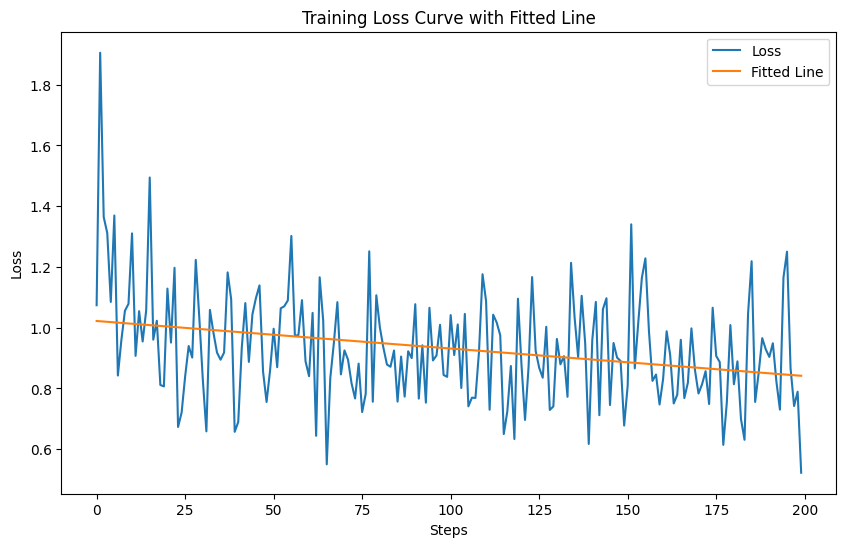

In [ ]:
import numpy as np

# Fit a straight line to the loss curve
coefficients = np.polyfit(range(len(loss_values)), loss_values, 1)
slope, intercept = coefficients

# Generate the y values for the straight line
straight_line_values = [slope * x + intercept for x in range(len(loss_values))]

# Plot the loss curve and the straight line
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Loss')
plt.plot(straight_line_values, label='Fitted Line')
plt.title('Training Loss Curve with Fitted Line')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


This part we are going to infer the finetuned model. Notice how we make sure that our tokenizer is in the correct format just like we did before finetuning.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "chatml", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Unsloth: Not a fast tokenizer, so can't process it as of yet :(
Please log a Github issue if you want this as a new feature!
Your chat template will still work, but it won't add or edit tokens.


['<|im_start|>user\nContinue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|im_end|>\n<|im_start|>assistant\nThe next number in the Fibonacci sequence is 13. So, the sequence continues as: 1, 1, 2, 3, 5, 8, 13.<|im_end|>\n<|im_start|>user\nWhat is the sum']

For cooler effect we can use TextStreamer to stream the tokens as they are generated by the model instead of waiting for the whole sentence to complete and then see the output all at once.

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Write a c program to add two numbers"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|im_start|>user
Write a c program to add two numbers<|im_end|>
<|im_start|>assistant
#include <stdio.h>

int main() {
  int num1, num2, sum;

  printf("Enter first number: ");
  scanf("%d", &num1);

  printf("Enter second number: ");
  scanf("%d", &num2);

  sum = num1 + num2;

  printf("The sum of the two numbers is: %d", sum);

  return 0;
}<|im_end|>
<|im_start|>user
Write a c program to find


Here we are saving the lora adapters in local memory or pushing it to HF.
This is not the whole model, just the adapters, we will merge it with base model later to create a complete finetuned model.

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("glouriousgautam/Mistral_v03_4bit_short_assistant", token = "...") # Online saving
# tokenizer.push_to_hub("glouriousgautam/Mistral_v03_4bit_short_assistant", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json')

Lets us check the lora adapaters for inference before we merge and upload our model to HF.

In [ ]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "What is a famous tall tower in Paris?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1365: UserWarning: Current model requires 125829120.0 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

Notice here how I am uploading my model to `glouriousgautam/Mistral_v03_4bit_short_assistant` and we have to pass our hf token here `token = "..."`, it would be a long string.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if True: model.push_to_hub_merged("glouriousgautam/Mistral7b_v03_short_chat", tokenizer, save_method = "merged_16bit", token = "...")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "...")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

Unsloth: You are pushing to hub, but you passed your HF username = glouriousgautam.
We shall truncate glouriousgautam/Mistral7b_v03_short_chat to Mistral7b_v03_short_chat
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 4.1G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 2.64 out of 12.67 RAM for saving.


100%|██████████| 32/32 [08:14<00:00, 15.46s/it]


Unsloth: Saving tokenizer...

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

 Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving Mistral7b_v03_short_chat/pytorch_model-00001-of-00003.bin...
Unsloth: Saving Mistral7b_v03_short_chat/pytorch_model-00002-of-00003.bin...
Unsloth: Saving Mistral7b_v03_short_chat/pytorch_model-00003-of-00003.bin...


README.md:   0%|          | 0.00/614 [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/glouriousgautam/Mistral7b_v03_short_chat


#### Successfully finetuned Mistral-7b_v0.3 on our instruction dtataset!